In [1]:
import random
import numpy as np
import numba as nb
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import seaborn as sns
sns.set_style("whitegrid")

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{dsfont}'}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 370.38374    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * ratio  # height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

We first generate a TCR pool with three individuals and a richness of 1500.

In [2]:
richness = 1500

probands = 3

tcr_range = range(richness)

The individuals have shifted TCR distributions.

In [3]:
individuals = np.zeros([probands,richness])
sampling_probs123 = np.zeros([probands,richness])
sampling_probs12 = np.zeros([2,richness])
sampling_probs13 = np.zeros([2,richness])
sampling_probs23 = np.zeros([2,richness])

individuals[0,0:1000] = 100*np.ones(1000)
individuals[1,250:1250] = 100*np.ones(1000)
individuals[2,500:1500] = 100*np.ones(1000)

sampling_probs123[0,0:1000] = 1e-3
sampling_probs123[1,250:1250] = 1e-3
sampling_probs123[2,500:1500] = 1e-3

sampling_probs12[0,0:1000] = 1e-3
sampling_probs12[1,250:1250] = 1e-3

sampling_probs13[0,0:1000] = 1e-3
sampling_probs13[1,500:1500] = 1e-3

sampling_probs23[0,250:1250] = 1e-3
sampling_probs23[1,500:1500] = 1e-3

The following arrays are used to sample certain cell types.

In [4]:
pool = np.zeros([probands,100*1000])

for i in range(1000):
    pool[0,i*100:(i+1)*100]= i*np.ones(100)
    pool[1,i*100:(i+1)*100]= (i+250)*np.ones(100)
    pool[2,i*100:(i+1)*100]= (i+500)*np.ones(100)

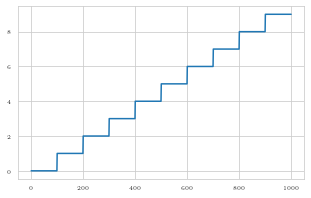

In [5]:
plt.plot(pool[0,0:1000])

Function to calculate overlaps between individuals 1 and 2, 1 and 3, 2 and 3, and 1--3.

In [6]:
def overlap(set1,set2,set3,richness):
  relative_overlap_12 = len(set(set1.intersection(set2)))/richness
  relative_overlap_13 = len(set(set1.intersection(set3)))/richness
  relative_overlap_23 = len(set(set2.intersection(set3)))/richness
  relative_overlap_123 = len(set((set1.intersection(set2)).intersection(set3)))/richness

  return relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123

In [7]:
sample1 = random.sample(pool[0].tolist(),6000)
sample2 = random.sample(pool[1].tolist(),6000)
sample3 = random.sample(pool[2].tolist(),6000)

In [8]:
set1 = set(sample1)
set2 = set(sample2)
set3 = set(sample3)

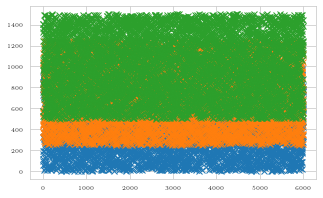

In [9]:
plt.plot(sample1,'x');
plt.plot(sample2,'x');
plt.plot(sample3,'x');

Compute the expected overlap.

In [10]:
@jit(nopython=True,parallel=True)
def moments_KM(Omega,M,p,N):
    
    KM = 0
    cross_terms_KM = 0
    
    for i in nb.prange(Omega):
        for j in range(i,Omega):
            product_i = 1
            product_ij = 1

            for m in range(M):
                
                if i == 0:
                    product_i *= (1-(1-p[m,j])**N)
                    
                if i != j:
                    product_ij *= 1+(1-p[m,i]-p[m,j])**N-(1-p[m,i])**N-(1-p[m,j])**N
            
            if i == 0:
                KM += product_i
            
            if i != j:
                cross_terms_KM += 2*product_ij
            
    expected_KM = KM
    variance_KM = expected_KM+cross_terms_KM-expected_KM**2
    
    return expected_KM, np.sqrt(variance_KM)

In [11]:
mean, std = moments_KM(richness,2,sampling_probs12,3000)

In [12]:
mean, std

(677.2849005907035, 7.6249188450388425)

Plot abundance and overlaps for different sample sizes.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
<ipython-input-13-5748223e7dfa>:95: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


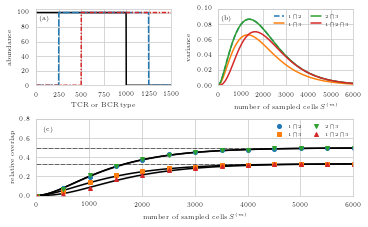

In [13]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AB
    CC
    """
)

axd["A"].plot(tcr_range,individuals[0,:],color="k")
axd["A"].plot(tcr_range,individuals[1,:],linestyle=(0, (5, 1)))
axd["A"].plot(tcr_range,individuals[2,:],color="tab:red",linestyle=(0, (3, 1, 1, 1)))

axd["A"].set_xlim(0,1500)
axd["A"].set_ylim(0,105)
axd["A"].set_xlabel(r"TCR or BCR type")
axd["A"].set_ylabel(r"abundance")
axd["A"].text(0.02*1500,0.85*105,r"(a)")

relative_overlap_12_arr = []
relative_overlap_13_arr = []
relative_overlap_23_arr = []
relative_overlap_123_arr = []
sample_size_arr = np.arange(10,6500,100)

for sample_size in sample_size_arr:
  sample1 = random.sample(pool[0].tolist(),sample_size)
  sample2 = random.sample(pool[1].tolist(),sample_size)
  sample3 = random.sample(pool[2].tolist(),sample_size)
  set1 = set(sample1)
  set2 = set(sample2)
  set3 = set(sample3)

  relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123 = overlap(set1,set2,set3,richness)
  relative_overlap_12_arr.append(relative_overlap_12)
  relative_overlap_13_arr.append(relative_overlap_13)
  relative_overlap_23_arr.append(relative_overlap_23)
  relative_overlap_123_arr.append(relative_overlap_123)

axd["C"].hlines(750/richness,0,6000,colors="k",ls=(0, (5, 1)),linewidth=1.0,alpha=0.6)
axd["C"].hlines(500/richness,0,6000,colors="k",ls=(0, (5, 1)),linewidth=1.0,alpha=0.6)

arr = [moments_KM(richness,2,sampling_probs12,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.5,color='k')
axd["C"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[x[1]**2/richness for x in arr],ls="--",label=r"$1\bigcap 2$")

arr = [moments_KM(richness,2,sampling_probs13,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.5,color='k')
axd["C"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[x[1]**2/richness for x in arr],label=r"$1\bigcap 3$")

arr = [moments_KM(richness,2,sampling_probs23,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.5,color='k')
axd["C"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[x[1]**2/richness for x in arr],label=r"$2\bigcap 3$")

arr = [moments_KM(richness,3,sampling_probs123,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.5,color='k')
axd["C"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[x[1]**2/richness for x in arr],label=r"$1\bigcap 2 \bigcap 3$")

axd["C"].plot(sample_size_arr[::5],relative_overlap_12_arr[::5],'o',label=r"$1\bigcap 2$",markersize=4)
axd["C"].plot(sample_size_arr[::5],relative_overlap_13_arr[::5],'s',label=r"$1\bigcap 3$",markersize=4)
axd["C"].plot(sample_size_arr[::5],relative_overlap_23_arr[::5],'v',label=r"$2\bigcap 3$",markersize=4)
axd["C"].plot(sample_size_arr[::5],relative_overlap_123_arr[::5],'^',label=r"$1\bigcap 2\bigcap 3$",markersize=4)

axd["C"].text(0.02*6000,0.85*0.8,r"(c)")

axd["C"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["C"].set_xlim(0,6000)
axd["C"].set_ylim(0,0.8)
axd["C"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["C"].set_ylabel(r"relative overlap")

#axd["B"].text(0.02*6000,0.85*0.8,r"(b)")

axd["B"].text(0.02*6000,0.85*0.1,r"(b)")
axd["B"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["B"].set_xlim(0,6000)
axd["B"].set_ylim(0,0.1)
axd["B"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["B"].set_ylabel(r"variance")

plt.tight_layout()
plt.savefig("overlap_sampling_numba.svg",dpi=300)
plt.show()

/home/lucasb/anaconda3/envs/TCR/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


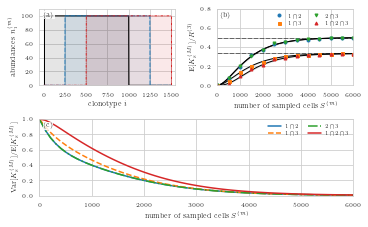

In [14]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AB
    CC
    """
)

axd["A"].plot(tcr_range,individuals[0,:],color="k",lw=1)
axd["A"].plot(tcr_range,individuals[1,:],color="tab:blue",linestyle=(0, (5, 1)),lw=1)
axd["A"].plot(tcr_range,individuals[2,:],color="tab:red",linestyle=(0, (3, 1, 1, 1)),lw=1)

axd["A"].fill_between(tcr_range,individuals[0,:],0,color="k",alpha=0.1)
axd["A"].fill_between(tcr_range,individuals[1,:],0,color="tab:blue",alpha=0.1)
axd["A"].fill_between(tcr_range,individuals[2,:],0,color="tab:red",alpha=0.1)

axd["A"].vlines(0,100,0,colors="k",linewidths=1)
axd["A"].vlines(1500,100,0,colors="tab:red",linestyles=(0, (3, 1, 1, 1)),linewidths=1)

axd["A"].set_xlim(-50,1550)
axd["A"].set_ylim(0,110)
axd["A"].set_xlabel(r"clonotype $i$")
axd["A"].set_ylabel(r"abundances $n_i^{(m)}$")
text = axd["A"].text(-5,0.9*110,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

relative_overlap_12_arr = []
relative_overlap_13_arr = []
relative_overlap_23_arr = []
relative_overlap_123_arr = []
sample_size_arr = np.arange(10,6500,100)

for sample_size in sample_size_arr:
  sample1 = random.sample(pool[0].tolist(),sample_size)
  sample2 = random.sample(pool[1].tolist(),sample_size)
  sample3 = random.sample(pool[2].tolist(),sample_size)
  set1 = set(sample1)
  set2 = set(sample2)
  set3 = set(sample3)

  relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123 = overlap(set1,set2,set3,richness)
  relative_overlap_12_arr.append(relative_overlap_12)
  relative_overlap_13_arr.append(relative_overlap_13)
  relative_overlap_23_arr.append(relative_overlap_23)
  relative_overlap_123_arr.append(relative_overlap_123)

axd["B"].hlines(750/richness,0,6000,colors="k",ls=(0, (5, 1)),linewidth=1.0,alpha=0.6)
axd["B"].hlines(500/richness,0,6000,colors="k",ls=(0, (5, 1)),linewidth=1.0,alpha=0.6)

arr = [moments_KM(richness,2,sampling_probs12,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.0,color='k')
axd["B"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr],label=r"$1\bigcap 2$")

arr = [moments_KM(richness,2,sampling_probs13,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.0,color='k')
axd["B"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr],ls="--",label=r"$1\bigcap 3$")

arr = [moments_KM(richness,2,sampling_probs23,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.0,color='k')
axd["B"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr],ls="-.",label=r"$2\bigcap 3$")

arr = [moments_KM(richness,3,sampling_probs123,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[x[0]/richness for x in arr],linewidth=1.0,color='k')
axd["B"].fill_between(sample_size_arr,
                   [(arr[i][0]-arr[i][1])/richness for i in range(len(arr))],
                   [(arr[i][0]+arr[i][1])/richness for i in range(len(arr))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr],label=r"$1\bigcap 2 \bigcap 3$")

axd["B"].plot(sample_size_arr[::5],relative_overlap_12_arr[::5],'o',label=r"$1\bigcap 2$",markersize=3)
axd["B"].plot(sample_size_arr[::5],relative_overlap_13_arr[::5],'s',label=r"$1\bigcap 3$",markersize=3)
axd["B"].plot(sample_size_arr[::5],relative_overlap_23_arr[::5],'v',label=r"$2\bigcap 3$",markersize=3)
axd["B"].plot(sample_size_arr[::5],relative_overlap_123_arr[::5],'^',label=r"$1\bigcap 2\bigcap 3$",markersize=3)

text = axd["B"].text(0.02*6000,0.9*0.8,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

axd["B"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["B"].set_xlim(0,6000)
axd["B"].set_ylim(0,0.8)
axd["B"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["B"].set_ylabel(r"$\mathds{E}[K_{\rm s}^{(M)}]/R^{(3)}$")

text = axd["C"].text(0.01*6000,0.9*1,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
axd["C"].legend(loc=1,ncol=2,fontsize=5,frameon=False,handlelength=2.6)
axd["C"].set_xlim(0,6000)
axd["C"].set_ylim(0,1)
axd["C"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["C"].set_ylabel(r"$\mathrm{Var}[K_{\rm s}^{(M)}]/\mathds{E}[K_{\rm s}^{(M)}]$")

plt.tight_layout()
plt.savefig("overlap_sampling_numba_fano.svg",dpi=300)
plt.show()